In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\american_sign_language.PNG
C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\amer_sign2.png
C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\amer_sign3.png
C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_test.csv
C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_train.csv
C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_test\sign_mnist_test.csv
C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_train\sign_mnist_train.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Loading the ASL dataset

In [5]:
train_df = pd.read_csv(r'C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_train\sign_mnist_train.csv')
test_df = pd.read_csv(r'C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_test\sign_mnist_test.csv')

In [6]:
temp = pd.read_csv(r'C:\Users\famil\Documents\GitHub\Sign-Language-Translation\sign-language-mnist\sign_mnist_test\sign_mnist_test.csv')
y = temp['label']

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

In [8]:
# plt.figure(figsize = (10,10)) # Label Count
# sns.set_style("darkgrid")
# sns.countplot(train_df['label'])

**The dataset seems balanced as for each training label , enough training examples exist**

In [9]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [11]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [12]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [13]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

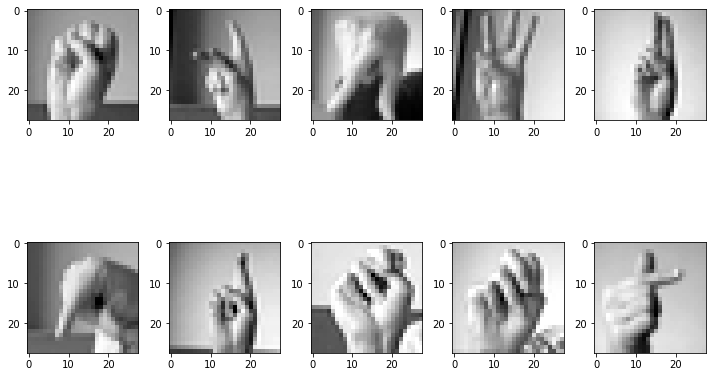

In [14]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 10
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [15]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE
**A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.**

* **A convolution does this by multiplying two matrices and yielding a third, smaller matrix.**
* **The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.**
* **In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure**
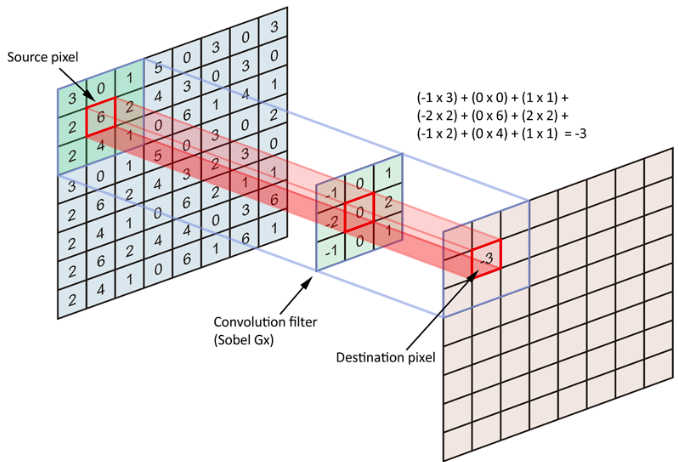

# Training The Model

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [17]:
model = Sequential(name='kaggle')
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "kaggle"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0    

In [4]:
# history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs = 5, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction])

In [20]:
model = keras.models.load_model("p_model")

In [21]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 4s 16ms/step - loss: 0.1066 - accuracy: 0.9651
Accuracy of the model is -  96.51421904563904 %


# Analysis after Model Training

In [22]:
# epochs = [i for i in range(5)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(16,9)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
# ax[1].set_title('Testing Accuracy & Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Loss")
# plt.show()

In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

array([ 6,  5, 10,  0,  3], dtype=int64)

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       0.95      1.00      0.97       245
     Class 4       0.99      0.95      0.97       498
     Class 5       0.95      1.00      0.97       247
     Class 6       1.00      0.86      0.92       348
     Class 7       1.00      0.87      0.93       436
     Class 8       0.94      1.00      0.97       288
    Class 10       1.00      0.99      1.00       331
    Class 11       0.95      1.00      0.97       209
    Class 12       0.94      0.98      0.96       394
    Class 13       0.98      1.00      0.99       291
    Class 14       1.00      0.94      0.97       246
    Class 15       0.95      1.00      0.97       347
    Class 16       0.99      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       0.96    

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

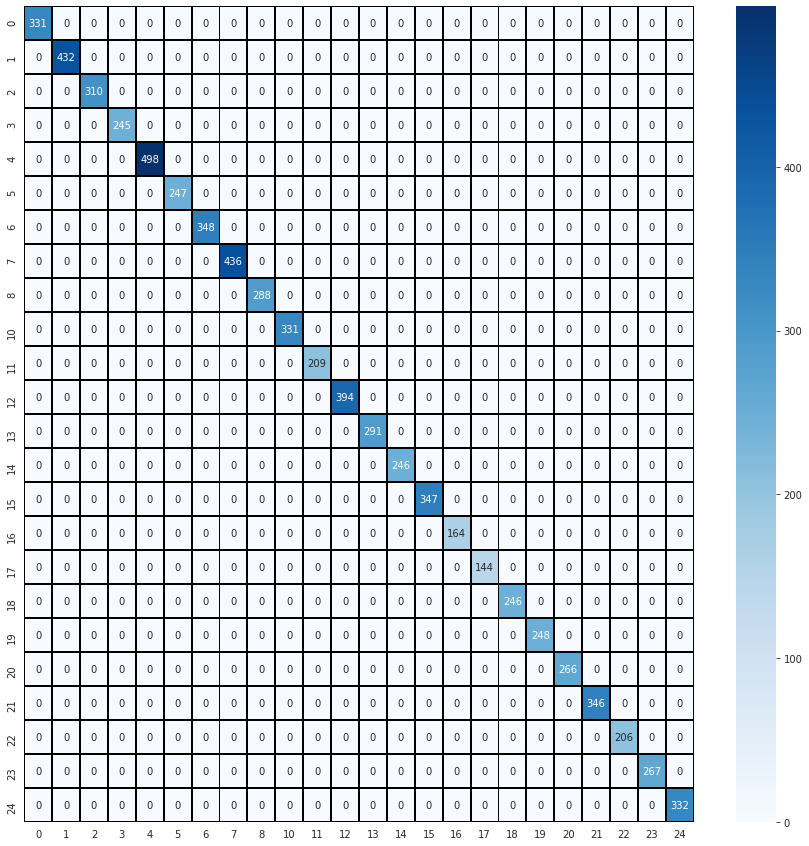

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y)[0]

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


**Some of the Correctly Predicted Classes**

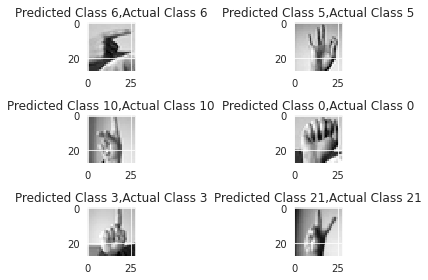

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(no_classes, activation='softmax'))

In [23]:
import PIL

In [25]:
file_name = r'C:\Users\famil\Pictures\Camera Roll\peter_hands\a_peter.jpg'
sign = PIL.Image.open(file_name).transpose(PIL.Image.FLIP_LEFT_RIGHT)
sign = sign.resize((28, 28), PIL.Image.LANCOZ)
arr = np.asarray(sign)
arr = arr/255.0
my_hand = arr[:,:,0].reshape((1,28,28,1))

In [27]:
my_hand.shape

(1, 28, 28, 1)

label: 
h
guess: 
i 0.63844925 [[2.60332529e-03 7.45436060e-04 1.56013648e-05 2.74216609e-06
  5.37872268e-03 1.25394305e-02 1.72362943e-05 1.15266273e-04
  6.38449252e-01 2.57268641e-03 9.08483798e-06 1.37678785e-02
  5.29906154e-03 1.28272141e-05 1.29819378e-01 4.21998811e-05
  5.36855019e-04 3.33700422e-03 1.38597423e-03 9.36659169e-04
  1.27783685e-04 3.02047032e-04 8.20538990e-05 1.81901336e-01]]


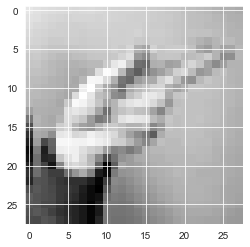

In [ ]:
plt.imshow(my_hand[0], cmap="gray")
my_guess = model.predict(my_hand)
print("label: ")
print(file_name[36:37])
print("guess: ")
print(label_dict[np.argmax(my_guess, axis=-1)[0]], max(my_guess[0]), my_guess)

label: 
r
guess: 
r [1.07974224e-13 6.47925757e-09 1.32008716e-13 1.04691503e-06
 5.71512455e-12 6.04931327e-10 1.82144595e-11 3.27566452e-13
 4.57408440e-08 7.59069808e-05 4.83430938e-07 1.34804487e-10
 2.38560473e-13 2.75824545e-12 4.94773378e-09 5.54775603e-09
 9.99298453e-01 1.61234637e-10 3.18458537e-10 5.90697629e-04
 3.32187228e-05 1.07176339e-08 5.95053062e-10 1.41801815e-08]


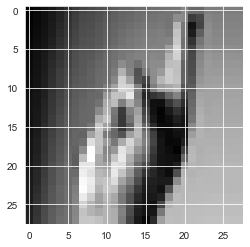

In [ ]:
imag, label = next(datagen.flow(x_train, y_train, batch_size=1))
plt.imshow(imag[0], cmap="gray")
guess_iter = model.predict(imag)
print("label: ")
print(label_dict[np.argmax(label[0], axis=-1)])
print("guess: ")
print(label_dict[np.argmax(guess_iter[0], axis=-1)], max(guess_iter))


In [ ]:
my_hand[0]

array([[[150],
        [152],
        [153],
        [153],
        [154],
        [155],
        [156],
        [157],
        [157],
        [159],
        [161],
        [163],
        [163],
        [165],
        [165],
        [167],
        [170],
        [171],
        [172],
        [171],
        [172],
        [173],
        [175],
        [175],
        [176],
        [177],
        [176],
        [176]],

       [[152],
        [153],
        [151],
        [153],
        [156],
        [156],
        [157],
        [157],
        [157],
        [160],
        [161],
        [163],
        [165],
        [165],
        [165],
        [169],
        [171],
        [171],
        [173],
        [173],
        [173],
        [174],
        [175],
        [177],
        [178],
        [178],
        [178],
        [179]],

       [[152],
        [152],
        [153],
        [154],
        [155],
        [156],
        [158],
        [159],
        [160],
        [161],
      

In [ ]:
x_train[0].reshape(1, 28, 28, 1)

array([[[[0.41960784],
         [0.4627451 ],
         [0.49803922],
         [0.5254902 ],
         [0.54509804],
         [0.56078431],
         [0.57254902],
         [0.58823529],
         [0.6       ],
         [0.61176471],
         [0.61960784],
         [0.62745098],
         [0.63921569],
         [0.64705882],
         [0.62352941],
         [0.65098039],
         [0.65882353],
         [0.66666667],
         [0.66666667],
         [0.67058824],
         [0.67058824],
         [0.67058824],
         [0.6745098 ],
         [0.67058824],
         [0.67058824],
         [0.66666667],
         [0.66666667],
         [0.6627451 ]],

        [[0.43529412],
         [0.4745098 ],
         [0.50588235],
         [0.52941176],
         [0.55294118],
         [0.56470588],
         [0.58039216],
         [0.59215686],
         [0.60392157],
         [0.61568627],
         [0.62745098],
         [0.63921569],
         [0.64313725],
         [0.66666667],
         [0.46666667],
         